## Pizza vs Clock Experiment (Linear)

### Setup

In [39]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
import tqdm

import random
import time

from pathlib import Path
import pickle
import os

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "colab"
import plotly.graph_objects as go

from torch.utils.data import DataLoader

from functools import *
import pandas as pd
import gc

# import comet_ml
import itertools
# a linear model implementing modular addition
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random

d_hidden=256
n_vocab=59
class MyModelD(nn.Module):
    def __init__(self):
        super(MyModelD, self).__init__()
        self.embed = nn.Embedding(n_vocab, d_hidden//2)
        self.unembed = nn.Embedding(n_vocab, d_hidden)
        self.l1 = nn.Linear(d_hidden, d_hidden, bias=True)
        self.embed.weight.data /= (d_hidden//2)**0.5
        self.unembed.weight.data /= d_hidden**0.5
        self.pause=False
    def backdoor_h(self, x):
        x = self.embed(x)
        x0 = x
        x = torch.cat([x[:,0],x[:,1]], dim=1)
        x = self.l1(x)
        x = F.relu(x)
        return x0,x
    def forward_h(self, x):
        _, x = self.backdoor_h(x)
        x = x @ self.unembed.weight.t()
        return _, x
    def backdoor(self,x):
        return self.backdoor_h(x)[1]
    def forward(self,x):
        return self.forward_h(x)[1]
class MyModelA(nn.Module):
    def __init__(self):
        super(MyModelA, self).__init__()
        self.embed = nn.Embedding(n_vocab, d_hidden)
        self.unembed = nn.Embedding(n_vocab, d_hidden)
        self.l1 = nn.Linear(d_hidden, d_hidden, bias=True)
        self.embed.weight.data /= (d_hidden//2)**0.5
        self.unembed.weight.data /= d_hidden**0.5
    def backdoor_h(self, x):
        x = self.embed(x)
        x0 = x
        assert len(x.shape)==3 and x.shape[1]==2
        x = self.l1(x[:,0]+x[:,1])
        x = F.relu(x)
        #x = self.l2(x)
        #x = F.relu(x)
        return x0,x
    def forward_h(self, x):
        _, x = self.backdoor_h(x)
        x = x @ self.unembed.weight.t()
        return _, x
    def backdoor(self,x):
        return self.backdoor_h(x)[1]
    def forward(self,x):
        return self.forward_h(x)[1]
class MyModelB(nn.Module):
    def __init__(self):
        super(MyModelB, self).__init__()
        self.embed = nn.Embedding(n_vocab, d_hidden)
        self.unembed = nn.Embedding(n_vocab, d_hidden)
        self.l1 = nn.Linear(d_hidden, d_hidden, bias=True)
        self.l2 = nn.Linear(d_hidden, d_hidden, bias=True)
        self.embed.weight.data /= (d_hidden//2)**0.5
        self.unembed.weight.data /= d_hidden**0.5
    def backdoor_h(self, x):
        x = self.embed(x)
        x0 = x
        assert len(x.shape)==3 and x.shape[1]==2
        x = self.l1(x[:,0]+x[:,1])
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        return x0, x
    def forward_h(self, x):
        _, x = self.backdoor_h(x)
        x = x @ self.unembed.weight.t()
        return _, x
    def backdoor(self,x):
        return self.backdoor_h(x)[1]
    def forward(self,x):
        return self.forward_h(x)[1]
class MyModelC(nn.Module):
    def __init__(self):
        super(MyModelC, self).__init__()
        self.embed = nn.Embedding(n_vocab, d_hidden)
        self.unembed = nn.Embedding(n_vocab, d_hidden)
        self.l1 = nn.Linear(d_hidden, d_hidden, bias=True)
        self.l2 = nn.Linear(d_hidden, d_hidden, bias=True)
        self.embed.weight.data /= (d_hidden//2)**0.5
        self.unembed.weight.data /= d_hidden**0.5
    def backdoor_h(self, x):
        x = self.embed(x)
        x0 = x
        assert len(x.shape)==3 and x.shape[1]==2
        x = self.l1(x[:,0])+self.l1(x[:,1])
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        return x0, x
    def forward_h(self, x):
        _, x = self.backdoor_h(x)
        x = x @ self.unembed.weight.t()
        return _, x
    def backdoor(self,x):
        return self.backdoor_h(x)[1]
    def forward(self,x):
        return self.forward_h(x)[1]

# make a dataset with pytorch
class MyDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.data = []
        for i in range(n_vocab):
            for j in range(n_vocab):
                self.data.append([i,j])
    def __getitem__(self, index):
        return torch.tensor(self.data[index],dtype=int).to(DEVICE),sum(self.data[index])%n_vocab
    def __len__(self):
        return len(self.data)

full_dataset=MyDataset()
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=59*59, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=59*59, shuffle=True)

DEVICE='cpu'#cuda:0'#+str(random.randint(0,1))
print(f'Running on',DEVICE)
import wandb
import tqdm
def train(config,silent=False):
    typ=config['model_type']
    models={'A':MyModelA,'B':MyModelB,'C':MyModelC,'D':MyModelD}
    # training loop
    model = models[typ]()
    model.to(DEVICE)
    def norm(model):
        su=0
        for t in model.parameters():
            su+=(t*t).sum().item()
        return su**0.5
    optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    def cross_entropy_high_precision(logits, labels):
        # Shapes: batch x vocab, batch
        # Cast logits to float64 because log_softmax has a float32 underflow on overly 
        # confident data and can only return multiples of 1.2e-7 (the smallest float x
        # such that 1+x is different from 1 in float32). This leads to loss spikes 
        # and dodgy gradients
        logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
        prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
        loss = -torch.mean(prediction_logprobs)
        return loss
    #criterion = nn.CrossEntropyLoss()
    bar = tqdm.tqdm(range(config['epoch'])) if not silent else range(config['epoch'])
    run = None#wandb.init(reinit=True,config=config,project='modadd_linears')#,settings=wandb.Settings(start_method="spawn"))
    for epoch in bar:
        for i, data in enumerate(train_loader):
            inputs, labels = map(lambda t:t.to(DEVICE),data)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = cross_entropy_high_precision(outputs, labels)
            loss.backward()
            optimizer.step()
        train_loss=loss.item()
        aa=('[TRAIN] epoch %d loss: %.3g ' % (epoch + 1, loss.item()))
        # also print validation loss & accuracy
        with torch.no_grad():
            total_loss = 0
            total_correct = 0
            total = 0
            for i, data in enumerate(test_loader):
                inputs, labels = map(lambda t:t.to(DEVICE),data)
                outputs = model(inputs)
                loss = cross_entropy_high_precision(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                total_correct += (predicted == labels).sum().item()
            val_loss=total_loss/len(test_loader)
            val_acc=total_correct/total
            cur_norm=norm(model)
            aa+=('[VAL] epoch %d loss: %.3g accuracy: %.3f norm: %.3f' % (epoch + 1, total_loss/len(test_loader), total_correct/total, norm(model)))
        try:
            bar.set_description(aa)
        except:
            continue
        if run:
            run.log({'training_loss': train_loss,
            'validation_loss': val_loss,
            'validation_accuracy': val_acc,
            'parameter_norm': cur_norm})
    return dict(
        model=model,
        config=config,
        dataset = full_dataset,
        run=run
    )

run_experiment=train

Running on cpu


### Load Trained Model

In [52]:
modelBeta='p71frej8t7'
modelDelta='qlvxqhkvit'
runid=modelBeta
import json
with open(f'save/config_{runid}.json','r') as f:
    config=json.load(f)
model_file=f'save/model_{runid}.pt'
C=59
print(config)
config.setdefault('diff_vocab',False)
config.setdefault('eqn_sign',False)
config['epoch']=2
result_modadd=run_experiment(config)
model=result_modadd['model']
dataset = result_modadd['dataset']
dataloader = torch.utils.data.DataLoader(dataset, batch_size=C*C)
model.load_state_dict(torch.load(model_file,map_location='cpu'))

{'C': 59, 'model_type': 'B', 'n_vocab': 59, 'd_model': 256, 'd_hidden': 256, 'epoch': 20000, 'lr': 0.001, 'weight_decay': 2.0, 'frac': 0.8, 'runid': 'p71frej8t7', 'func': None}


[TRAIN] epoch 2 loss: 4.07 [VAL] epoch 2 loss: 4.08 accuracy: 0.014 norm: 18.621: 100%|██████████| 2/2 [00:00<00:00, 14.08it/s]


<All keys matched successfully>

### Principal Component Visualization

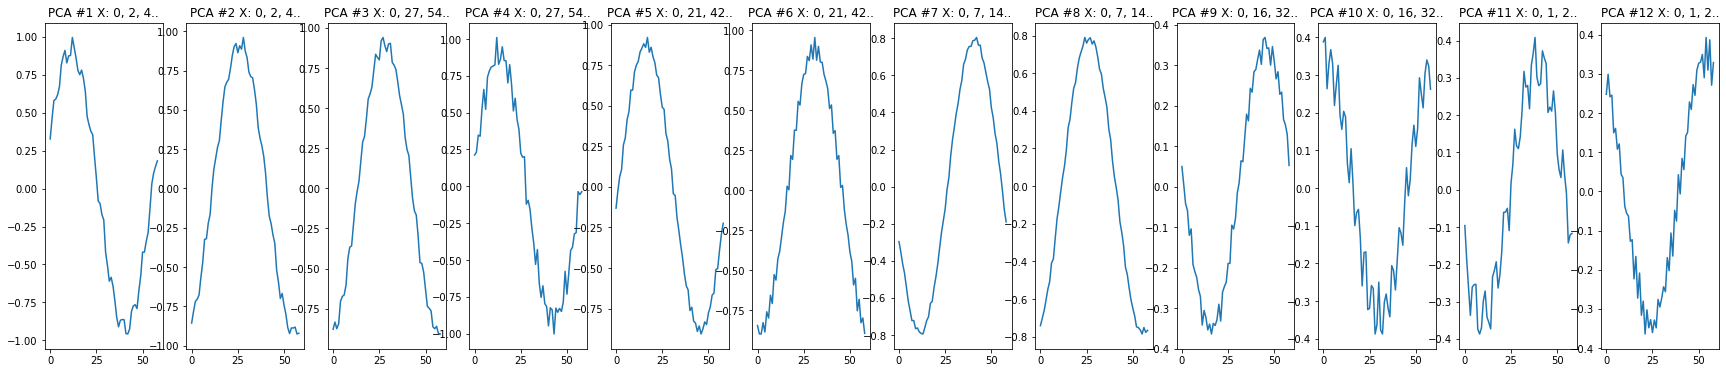

In [53]:
model.load_state_dict(torch.load(model_file,map_location=DEVICE))
# ok, now let's manipulate the embedding weights
we=model.embed.weight
# now use scikit PCA to reduce the dimensionality of the embedding
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
we2=pca.fit_transform(we.detach().cpu().numpy())
plt.figure(figsize=(30,6))
import math
pi=math.pi
for ix in range(12):
    vs=we2[:,ix]
    tt=[]
    for i in range(1,59):
        vv=[vs[t*i%59] for t in range(59)]
        sa=sum(vv[t]*(math.cos(2*pi/59*t)+1j*math.sin(2*pi/59*t)) for t in range(59))
        sa=-abs(sa)
#        sa=sum(abs(p-q) for p,q in zip(vv,vv[1:]))
        tt.append((sa,i))
    tt.sort()
    plt.subplot(1,12,ix+1)
    i=tt[0][1]
    i=min(i,59-i)
    v=[vs[t*i%59] for t in range(59)]
    plt.title(f'PCA #{ix+1} X: 0, {i}, {2*i%59}..')
    plt.plot(v)

### Gradient Symmetricity

In [54]:
model.load_state_dict(torch.load(model_file,map_location='cpu'))
model.to('cpu')
# we=model.embed.W_E.T
# from sklearn.decomposition import PCA
# pca = PCA(n_components=20)
# we2=pca.fit_transform(we.detach().cpu().numpy())
oc=None
tt=0
xs=[(a,b,c) for a in range(C) for b in range(C) for c in range(C)]
random.Random(42).shuffle(xs)
xs=xs[:100]
for abc in xs:#tqdm.tqdm(xs):
    a,b,c=abc
    x=torch.tensor([[a,b]],device='cpu')
    t,o0=model.forward_h(x)
    model.zero_grad()
    #print(a,b,c)
    #model.remove_all_hooks()
    o=o0[0,:]
    t.retain_grad()
    o[c].backward(retain_graph=True)
    tg=t.grad[0].detach().cpu().numpy()
    #tt+=tg[0][0]
    dp=np.sum(tg[0]*tg[1])/np.sqrt(np.sum(tg[0]**2))/np.sqrt(np.sum(tg[1]**2))
    tt+=dp
    #print(tg[0][0])
    #print(tg.shape)
    # ass=pca.transform(tg)
    # print(' & '.join(map(lambda t:f'{t:.2f}',ass[0][:30].tolist())))
    # print(' & '.join(map(lambda t:f'{t:.2f}',ass[1][:30].tolist())))
    # print(' & '.join(map(lambda t:f'{t:.2f}',tg[0][:6].tolist())))
    # print(' & '.join(map(lambda t:f'{t:.2f}',tg[1][:6].tolist())))
    # print(tg)
    #print(tt)
print(tt/len(xs))

1.0000000113248826


### Distance Irrelevance

Distance Irrelevance 0.23020491651951216


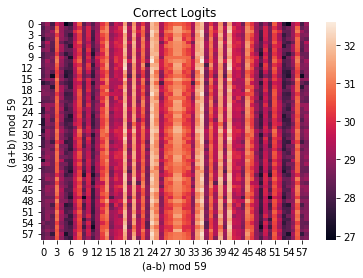

In [55]:
model=result_modadd['model']
model.load_state_dict(torch.load(model_file,map_location=DEVICE))
dataset = result_modadd['dataset']
dataloader = torch.utils.data.DataLoader(dataset, batch_size=C*C)
model = result_modadd['model']
oo=[[0]*C for _ in range(C)]
for x,y in dataloader:
    #print(x)
    with torch.inference_mode():
        model.eval()
        o=model(x)[:,:]
        o0=o[list(range(len(x))),y]
        o0=o0.cpu()
        x=x.cpu()
        for p,q in zip(o0,x):
            A,B=int(q[0].item()),int(q[1].item())
            oo[(A+B)%C][(A-B)%C]=p.item()
oo=np.array(oo)
import seaborn as sns
dd=np.mean(np.std(oo,axis=0))/np.std(oo.flatten())
sns.heatmap(np.array(oo))
plt.xlabel(f'(a-b) mod {C}')
plt.ylabel(f'(a+b) mod {C}')
plt.title('Correct Logits')
print('Distance Irrelevance',dd)

### Circularity

In [56]:
model.load_state_dict(torch.load(model_file,map_location=DEVICE))
we=model.embed.weight
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
import math
we2=pca.fit_transform(we.detach().cpu().numpy())
def ang(x):
    return math.cos(x)+math.sin(x)*1j
rst=0
first_k=4
for ix in range(first_k):
    vs=we2[:,ix]*1
    vs=vs/np.sqrt(np.sum(vs*vs))/math.sqrt(59)
    tt=[]
    for i in range(1,59):
        vv=[vs[t*i%59] for t in range(59)]
        sa=sum(vv[t]*ang(2*math.pi*t/59) for t in range(59))
        tt.append((-abs(sa)**2*2,i))
    tt.sort()
    i=tt[0][1]
    rst+=max(min(-tt[0][0],1.),0.)
    i=min(i,59-i)
    v=[vs[t*i%59] for t in range(59)]
rst/=first_k
print('Circularity',rst)

Circularity 0.9950419960676883


### Circle Isolation

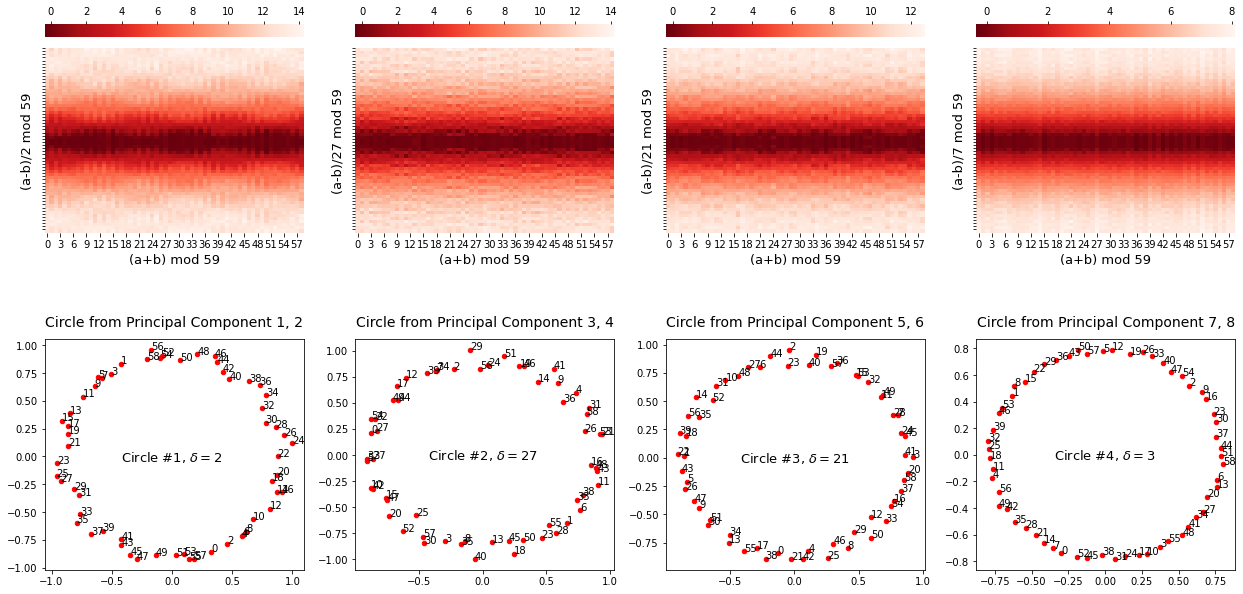

In [57]:
fig,ax=plt.subplots(2,4,figsize=(16/3*4,7/3*4))
ooo=[]
aa=[0,1,2,3,4,5,6,7] # put the desired dimensions here
for uu in range(0,8,2):
    model.load_state_dict(torch.load(model_file,map_location=DEVICE))
    # ok, now let's manipulate the embedding weights
    we=model.embed.weight
    # now use scikit PCA to reduce the dimensionality of the embedding
    from sklearn.decomposition import PCA
    pca = PCA(n_components=20)
    we2=pca.fit_transform(we.detach().cpu().numpy())
    X=aa[uu]
    Y=aa[uu+1]
    ax1=ax[1,uu//2]
    box = ax1.get_position()
    box.y0-=0.09
    box.y1-=0.09
    ax1.set_position(box)
    ax[1,uu//2].set_title(f'Circle from Principal Component {X+1}, {Y+1}',fontsize=14,y=1.03)
    ax[1,uu//2].scatter(we2[:C,X],we2[:C,Y],c='r',s=20)
    for i in range(C):
        ax[1,uu//2].annotate(str(i), (we2[i,X],we2[i,Y]))
    we2[:,16:]=0
    for i in range(16):
        if i not in [X,Y]: we2[:,i]=0
    we3=pca.inverse_transform(we2)
    model.embed.weight.data=torch.tensor(we3).to(model.embed.weight.device)
    oo=[[0]*C for _ in range(C)]
    for x,y in dataloader:
        with torch.inference_mode():
            model.eval()
            o=model(x)[:,:]
            ox=o[list(range(len(x))),y]
            ox=ox.cpu()
            x=x.cpu()
            for r,q in zip(ox,x):
                q0=int(q[0].item())
                q1=int(q[1].item())
                #q0=(q0//2)+(q0%2)*((C+1)//2)
                oo[int(q0+C-q1)%C][(q0+q1)%C]=r.item()
    minn=(float('inf'),float('inf'))
    #rearr(np.array(oo),ax[1,uu//2])
    for t in range(1,C):
        means=[np.mean(oo[i*t%C]) for i in range(C)]
        mean_diffs_avg=np.mean([abs(means[i]-means[(i+1)%C]) for i in range(C)])
        minn=min(minn,(mean_diffs_avg,t))
    t=minn[1]
    if t>C-t:
        t=C-t
    ox=[oo[i*t%C] for i in range(C)]
    # use seaborn to plot the heatmap of oo
    import seaborn as sns
    # heatmap at ax[1,uu//2], all y ticks are on
    sns.heatmap(np.array(ox),ax=ax[0,uu//2],cmap='Reds_r', cbar_kws = dict(use_gridspec=False,location="top"))
    ooo.append(np.array(ox))
    ax[1,uu//2].annotate(f'Circle #{X//2+1}, $\delta=$'+str(t//2 if X>=6 else t),(0,0),ha='center',va='center',fontsize=13)
    # enable all y ticks
    ax[0,uu//2].set_yticks(np.arange(0,C,1))
    ax[0,uu//2].set_ylabel(f'(a-b)/{t} mod {C}',fontsize=13)
    ax[0,uu//2].set_xlabel(f'(a+b) mod {C}',fontsize=13)

### Logit FVE

In [61]:
import math
inv=lambda t:pow(t,C-2,C)
# need to plug in deltas here
wk=[2*math.pi/59*inv(2),2*math.pi/59*inv(27),2*math.pi/59*inv(21)]
for uu in range(3):
    print(f'Circle #{uu+1}')
    model.load_state_dict(torch.load(model_file,map_location=DEVICE))
    we=model.embed.weight
    # now use scikit PCA to reduce the dimensionality of the embedding
    from sklearn.decomposition import PCA
    pca = PCA(n_components=20)
    we2=pca.fit_transform(we.detach().cpu().numpy())
    # modify dimension number here for different models
    X=uu*2
    Y=uu*2+1
    we2[:,16:]=0
    for i in range(16):
        if i not in [X,Y]: we2[:,i]=0
    we3=pca.inverse_transform(we2)
    model.embed.weight.data=torch.tensor(we3).to(model.embed.weight.device)
    ou=None
    for x,y in dataloader:
        with torch.inference_mode():
            model.eval()
            o=model(x)[:,:C]
            ou=o.reshape((C,C,C))
            #ou=o[list(range(len(x))),y].reshape((C,C))
            #ox=einops.repeat(ox,'a b->a b c',c=C)
            #ou=o.reshape((C,C,C))-ox
    oa=torch.zeros_like(ou,dtype=float)
    ob=torch.zeros_like(ou,dtype=float)
    oc=torch.zeros_like(ou,dtype=float)
    for i in range(C):
        for j in range(C):
            for k in range(C):
                from math import sin,cos
                oa[i][j][k]=cos(wk[uu]*(i+j-k))
                s=(cos(wk[uu]*i)+cos(wk[uu]*j),sin(wk[uu]*i)+sin(wk[uu]*j))
                co,si=cos(wk[uu]*k/2),sin(wk[uu]*k/2)
                ob[i][j][k]=abs(co*s[0]+si*s[1])-abs(-si*s[0]+co*s[1])
                g=(cos(wk[uu]*i-math.pi/4)+cos(wk[uu]*j-math.pi/4),sin(wk[uu]*i-math.pi/4)+sin(wk[uu]*j-math.pi/4))
                o0=(abs(s[0])-abs(s[1]))*math.cos(wk[uu]*k)+(abs(g[0])-abs(g[1]))*math.sin(wk[uu]*k)
                ci=cos(wk[uu]*i)
                cj=cos(wk[uu]*j)
                si=sin(wk[uu]*i)
                sj=sin(wk[uu]*j)
                o1=(abs(ci+cj)-abs(si+sj))*math.cos(wk[uu]*k)-(abs(ci+cj-si-sj)-abs(ci+cj+si+sj))*math.sin(wk[uu]*k)*(2**(-0.5))
                oc[i][j][k]=o1
    #ob=oa
    def npfy(x,n=False):
        try:
            x=x.detach()
        except:
            pass
        try:
            x=x.cpu()
        except:
            pass
        try:
            x=x.numpy()
        except:
            pass
        try:
            x=np.array(x)
        except:
            pass
        if n:
            x=(x-np.mean(x))/np.std(x)
        return x
    import sklearn
    pa=(sklearn.metrics.explained_variance_score(npfy(ou,1).flatten(),npfy(oa,1).flatten()))
    pb=(sklearn.metrics.explained_variance_score(npfy(ou,1).flatten(),npfy(ob,1).flatten()))
    pc=(sklearn.metrics.explained_variance_score(npfy(ou,1).flatten(),npfy(oc,1).flatten()))
    print("Qclock & Qpizza & Qpizza' (appendix)")
    print(f'{pa*100:.2f}% & {pb*100:.2f}% & {pc*100:.2f}%')

Circle #1
Qclock & Qpizza & Qpizza' (appendix)
75.27% & 97.99% & 98.03%
Circle #2
Qclock & Qpizza & Qpizza' (appendix)
74.71% & 97.48% & 97.57%
Circle #3
Qclock & Qpizza & Qpizza' (appendix)
75.46% & 98.22% & 98.13%


### 2D PCA Visualizations

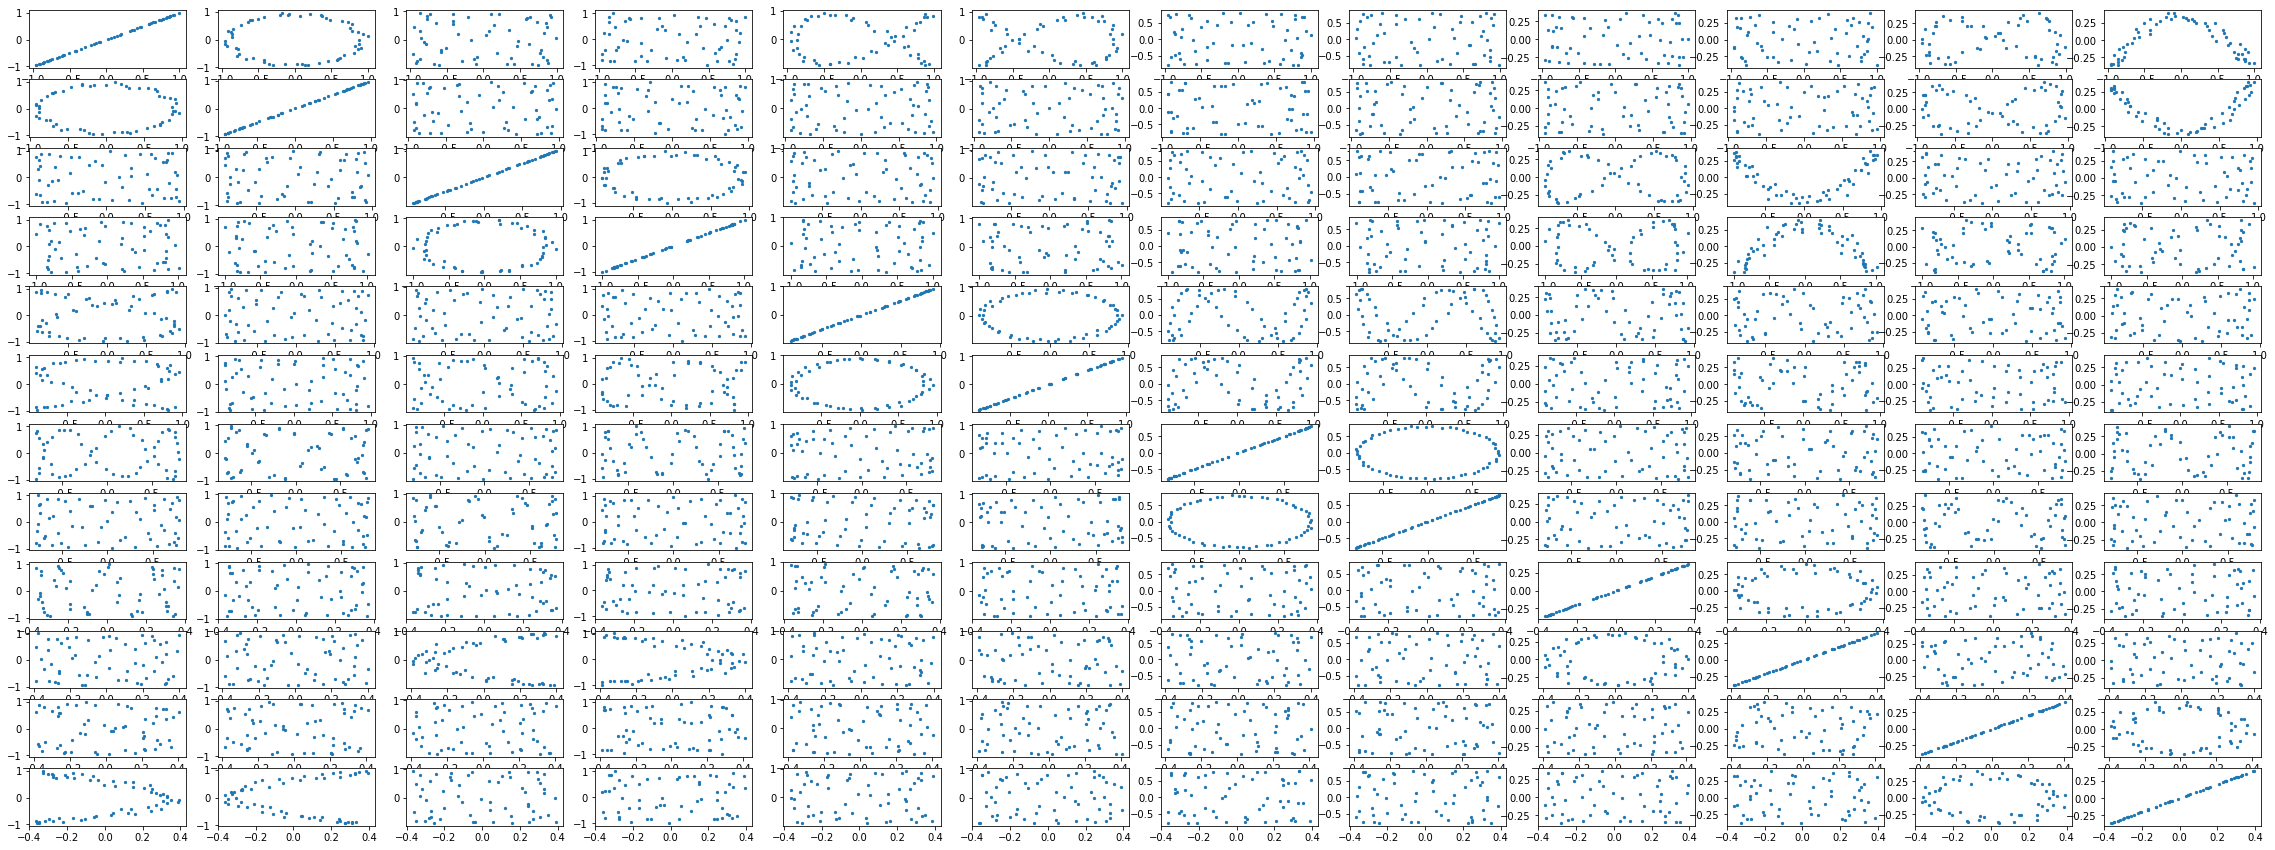

In [62]:
fig,ax=plt.subplots(12,12,figsize=(40,15))
model.load_state_dict(torch.load(model_file,map_location=DEVICE))
we=model.embed.weight.data
# now use scikit PCA to reduce the dimensionality of the embedding
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
we2=pca.fit_transform(we.detach().cpu().numpy())
for i in range(12):
    for j in range(12):
        ax[i,j].scatter(we2[:,i],we2[:,j],s=5)